In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

In [2]:
in_row = pd.read_excel('data/data.xlsx' ,index_col = 0)
temperature_values = in_row['Temperature'].values
date_values = in_row['Research_Date'].values

plt.style.use('ggplot')

In [3]:
row_count = len(temperature_values)
mean = np.sum(temperature_values) / row_count 


##### линейная модель (плато = c0 + c)
$\begin{equation*}
 \begin{cases}
   y = \frac{c}{a}h + c_{0}, \ h<a\\
   y = c + c_0, \ h>=a
 \end{cases}
\end{equation*}$

In [4]:
#semivariogramm models
sphire_model = lambda c0, c, a, h : c0 + c if (h > a) else (c0 + c * ((3 * h) / (2 * a)  - (1/2 * ((h/a)**3))))
pentasphire_model = lambda c0, c, a, h : c if (h >= a) else (c0 + ((c- c0) * ((15 / 8) * (h / a) - (5/4) * ((h / a)**3) + (3 / 8) * ((h / a)**5))))
exponential_model = lambda  c0, c, a, h : 0 if (h == 0) else (c0 + (c - c0) * (1 - math.exp( -3 * h / a)))
linalar_sem_model = lambda c0,c,a,h: c0 +  c if (h>=a) else ((c/a) * h + c0)

In [7]:
class SemivariogramModel:
    def __init__(self, model, c0, c, a):
        self.model = model
        self.c0 = c0
        self.c = c
        self.a = a
    
    def evaluate(self, h):
        return self.model(self.c0,self.c, self.a, abs(h))
    
np.array([1,2]) * np.array([2,4])
    


array([2, 8])

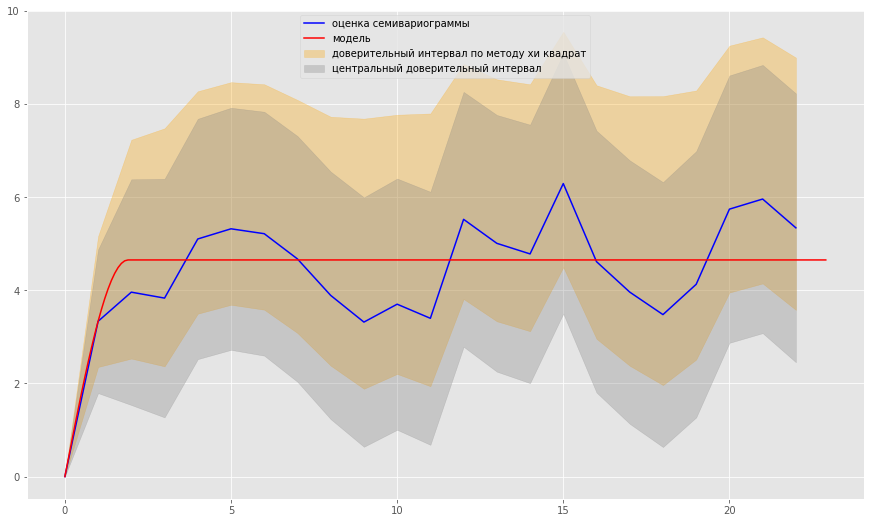

In [24]:
class Semivariogram:
    
    __evaluation_cash = dict()
    
    def __init__(self, series, model: SemivariogramModel) :
        self.series = series
        self.model = model
        self.lag_length = int(len(series) / 2)
        self.n = len(series)
        self.sem_args = [i for i in range(self.lag_length)]
        
    def get_series(self) :
        return self.series
    
        
    def print_semivariogram(self,
                            appraisalCCI = False,
                            model=False,
                            labels = False,
                            appraisalChi2 = False):
        fig = plt.figure()
        fig.set_figwidth(15)
        fig.set_figheight(9)
        plot = fig.add_subplot()
        plot.plot(self.sem_args, self.semivariogram(), label = 'оценка семивариограммы', color='blue')
        
        if(appraisalChi2):
            lb, ub = self.get_appraisalChi2()
            plot.fill_between(self.sem_args, lb, ub, color='orange', alpha=0.3,
                              label='доверительный интервал по методу хи квадрат')
        if(appraisalCCI):
            lb, ub = self.get_appraisalCCI()
            plot.fill_between(self.sem_args, lb, ub, color='grey', alpha=0.3, label='центральный доверительный интервал')
        if(model):
            ma, mv = self.get_model_values(0.1)
            plot.plot(ma, mv, color='r', label="модель")
        if(labels):
            plt.legend(loc=9)
            
            
            
    
    def local_appraisal_dispersion_semivariogram(self, h) :
        if(h < 0.000001):
            return 0
        sm = 0.
        for s in range(self.n-h):
            for t in range(self.n-h):
                sm += (self.model.evaluate(s-t+h) + self.model.evaluate(s-t-h) - 2*self.model.evaluate(s-t))**2
        return sm / (2 * ((self.n - h)**2))
    
    
    def appraisal_dispersion_semivariogram(self, force_update = False):
        return [self.local_appraisal_dispersion_semivariogram(h) for h in range(self.lag_length)]
    
    
    def local_semivariogram(self, h):
        sm = 0.
        for s in range(0, self.n - h):
            sm += (self.series[s+h] - self.series[s])**2
        return sm/(2*(self.n - h));
    
    
    def semivariogram(self, force_update = False):
        return [self.local_semivariogram(h) for h in range(self.lag_length)]
    
    
    def get_model_values(self, step):
        model_arg = np.arange(0,self.lag_length,step)
        return model_arg, [self.model.evaluate(h) for h in model_arg]
    
        
    def get_appraisalCCI(self) :
        sem_values = self.semivariogram()
        quantil = 1.96 #TODO change to inverse laplaze function
        sqrt_app_dispersion = np.array(self.appraisal_dispersion_semivariogram())**0.5
        lower_bound = np.array(sem_values) - quantil * sqrt_app_dispersion
        upper_bound = np.array(sem_values) + quantil * sqrt_app_dispersion
        return lower_bound, upper_bound
    
    
    def get_appraisalChi2(self):
        lb = []
        ub = []
        sem = self.semivariogram()
        for h in range(self.lag_length):
            if h < 0.001 :
                lb.append(0.)
                ub.append(0.)
                continue
            app_disp = self.local_appraisal_dispersion_semivariogram(h)
            st_free = (2 * sem[h]**2)/app_disp
            lb.append(st_free * sem[h] / stats.chi2.ppf(0.95,st_free))
            ub.append(st_free * sem[h] / stats.chi2.ppf(0.05,st_free))
        return lb, ub




        

test = Semivariogram(temperature_values,  SemivariogramModel(sphire_model, 0, np.var(temperature_values),1.9))
test.print_semivariogram(model=True, appraisalCCI=True, labels=True, appraisalChi2=True)




In [ ]:
#оценка для семивариограммы
def evaluation_semivariogram(series, h):
    #a = np.array(series[h:])
    #b = np.array(series[:len(series)-h])
    #return np.var(a-b)/2
    n = len(series)
    sm = 0.
    for s in range(0, n-h):
        sm += (series[s+h] - series[s])**2
    return sm/(2*(n-h));

def apprasial_semivariogram_dispersion(model, c0,c,a, n, h) :
    sm = 0.
    for s in range(n-h):
        for t in range(n-h):
            sm += ((model(c0,c,a,abs(s-t+h)) + model(c0,c,a,abs(s-t-h)) - 2*model(c0,c,a,abs(s-t)))**2)
    return sm / (2 * ((n - h)**2))


#построение граффика + модели
def semivariogram(x, y,
                  model = lambda c0, c, a : 0,
                  c0 = 0, c = 0, a = 0,
                  label = 'семивариограмма',
                  showModel = False,
                  showModelCoef = False,
                  appraisalCCI = False,
                  apparsialChi2 = False):
    lag_length = int(len(x) * 1/2)
    sem_values = [evaluation_semivariogram(y, h) for h in range(lag_length)]
    
    
    print(label)
    
    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(9)
    plot = fig.add_subplot()
    
    plot.plot([i for i in range(lag_length)], sem_values, label = 'оценка семивариограммы', color='blue')
    
    if(showModel) :
        if(showModelCoef) :
            print(f'c0 = {c0}, c = {c}, a = {a}')
        xModel = np.arange(0, lag_length, 0.1) 
        spModel = [model(c0,c,a,h) for h in xModel]
        plot.plot(xModel, spModel, color='r', label="модель")
         
    if(appraisalCCI) :
        quantil = 1.96
        sqrt_app_dispersion = (np.array([apprasial_semivariogram_dispersion(model, c0,c,a, len(y), h) for h in range(lag_length)])**(1/2))
        lower_bound = np.array(sem_values) - quantil * sqrt_app_dispersion
        upper_bound = np.array(sem_values) + quantil * sqrt_app_dispersion
        plot.fill_between([i for i in range(lag_length)], lower_bound, upper_bound, color='grey', alpha=0.3, label='центральный доверительный интервал')

    if(apparsialChi2) :
        l_bound = []
        u_buond = []
        for h in range(lag_length):
            if h == 0:
                l_bound.append(0.)
                u_buond.append(0.)
                continue
            app_disp = apprasial_semivariogram_dispersion(model, c0,c,a, len(y), h)
            st_free = (2 * sem_values[h]**2)/app_disp
            l_bound.append(st_free * sem_values[h] / stats.chi2.ppf(0.95,st_free))
            u_buond.append(st_free * sem_values[h] / stats.chi2.ppf(0.05,st_free))
    
        plot.fill_between([i for i in range(lag_length)], l_bound, u_buond, color='orange', alpha=0.3, label='доыерительный интервал по методу хи квадрат')
            
    plt.legend(loc=9)
    plt.show()
    return

In [ ]:
#input_row_variogram_analysis
_ = semivariogram(date_values, temperature_values, label="семивариограмма для исходного ряда")


In [ ]:
f = np.array([1,2,3])
f **= 2
print(f)

### Уравнение для линейной регрессии

In [ ]:
#regression
regression = LinearRegression();
model = regression.fit(np.array([i for i in range(row_count)]).reshape(-1,1), temperature_values)
intercept = model.intercept_
coef = model.coef_[0]
print(f' Y(t) = {coef} * t + {intercept} ') 

In [ ]:
#remainders row
remainders = [temperature_values[i] - intercept - coef * i for i in range(row_count)]
var = np.var(remainders)

### Оценки семивариограммы остатков

In [ ]:
#remainders_row_variogram_analysis
a_psp = 2.3
c0_psp = 0
c_psp = var - c0_psp;

semivariogram(date_values,
              remainders,
              pentasphire_model,
              c0 = c0_psp,
              c = c_psp,
              a = a_psp,
              label = 'семивариограмма + пентасферическая модель',
              showModelCoef = True,
              showModel = True,
              appraisalCCI = True,
              apparsialChi2 = True)

In [ ]:
#семивариограмма + пентасферическая модель(с эффектом сомородка)
#плато = с

a_psp_n = 5.1
c0_psp_n = 2.66
c_psp_n = var;

semivariogram(date_values, remainders,pentasphire_model,  c0 = c0_psp_n, c = c_psp_n, a = a_psp_n,
              label = 'семивариограмма + пентасферическая модель(с эффектом сомородка)', showModelCoef = True, showModel = True, appraisalCCI = True,
              apparsialChi2 = True)

In [ ]:
#семивариограмма + экспотенциальная модель
#плато = с
a_exp_n = 2.4
c0_exp_n = 0
c_exp_n = var
semivariogram(date_values, remainders,exponential_model,  c0 = c0_exp_n, c = c_exp_n ,a = a_exp_n,
              label = 'семивариограмма + экспотенциальная модель', showModelCoef = True, showModel = True, appraisalCCI = True,apparsialChi2 = True);

In [ ]:
a_sp = 2
c0_sp = 0
c_sp = var - c0_sp
semivariogram(date_values, remainders,sphire_model, c0 = c0_sp, c = c_sp,
              a = a_sp, label = 'семивариограмма + сферическая модель', showModelCoef = True, showModel = True, appraisalCCI = True,apparsialChi2 = True);

In [ ]:
#семивариограмма + сферическая модель(с эффектом сомородка)
#плато = с0 + с

a_sp_n = 4.2
c0_sp_n = 2.66
c_sp_n = var - c0_sp_n
semivariogram(date_values, remainders,sphire_model, c0 = c0_sp_n, c = c_sp_n,
              a = a_sp_n, label = 'семивариограмма + сферическая модель(с эффектом сомородка)', showModelCoef = True, showModel = True, appraisalCCI = True,apparsialChi2 = True);

In [ ]:
a_lin = 1.4
c0_lin = 0
c_lin = var - c0_lin
semivariogram(date_values, remainders, linalar_sem_model, c0 = c0_lin, c = c_lin, a = a_lin,
              label = 'семивариограмма + линейная модель', showModelCoef = True, showModel = True, appraisalCCI = True,apparsialChi2 = True);

In [ ]:
a_lin_n = 3
c0_lin_n = 2.66
c_lin_n = var - c0_lin_n
sem_values = semivariogram(date_values, remainders, linalar_sem_model, c0 = c0_lin_n, c = c_lin_n, a = a_lin_n,
              label = 'семивариограмма + линейная модель(с эффектом сомородка)', showModelCoef = True, showModel = True, appraisalCCI = True,apparsialChi2 = True);

#### Построение центрального доверительного интервала

In [ ]:
np.array([4,6]) / np.array([2,2])